In [8]:
%pylab inline
import math
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\dajka\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sign']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
D = 3 # Dimensions
N = 64 # Number of atoms in the cell
m = 39.948 # Atom mass in u
L = 10.0 # cell lenght
V  = L**D
rho = 1.374  # density
epsilon = 0.99774
sigma = 0.34
r_Cut = L/2 # Cutoff distance
n_steps = 10000
dt = 0.0032 #stepsize
sample_freq = 100 # Frequency of writing in the xyz file
TRequested = 0.5

In [10]:
pos = zeros([N,D])
        
pos = genfromtxt('Ar_64_cubic.xyz') # Load positions from file I got from the assigment
pos = pos[:,:D]/L

M_c = sum(pos, axis=0) / N # Center of mass

u_shift = 4.0 / (r_Cut**12) - 4.0 / (r_Cut**6) # Shift in the potential

for i in range(D):
    pos[:,i] = pos[:,i] - M_c[i]
    
def sign(a, b):
    if (b >=  0.0): return abs(a)
    else: return  - abs(a)

In [11]:
def Forces(pos,a,E_pot,epsilon,L,D,N):
    
    Sij = zeros(D) # Scaled distance
    Rij = zeros(D) # Real distance
    
    E_pot = E_pot * 0.0 # Potentail energy
    a = a * 0.0     # Acceleration
    w = 0.0       # Virial
    
    for i in range(N-1):
        
        for j in range(i + 1,N):
            
            Sij = pos[i,:] - pos[j,:]
            
            for l in range(D):
                
                if (abs(Sij[l]) > 0.5):
                    
                    Sij[l] = Sij[l] - sign(1.0,Sij[l]) # If distance is greater than 0.5 then find closer atom
            
            Rij = L * Sij # Scaled to real value
            Rsqij = dot(Rij, Rij) # r^2
            
            if(Rsqij < r_Cut**2): # Inside cutoff distance
                
                r2 = 1.0 / Rsqij 
                r6 = r2**3.0  
                r12 = r6**2.0 
                
                U = epsilon * (4.0 * (r12 - r6) - u_shift) # LJ potential
                F = epsilon * 24.0 * r2 * (2.0 * r12 - r6)   # Force
                
                E_pot[i] = E_pot[i] + 0.5 * U # Potential energy
                E_pot[j] = E_pot[j] + 0.5 * U 
                
                w = w + F * sqrt(Rsqij)  # Virial
                
                a[i,:] = a[i,:] + F * Sij # Acceleration
                a[j,:] = a[j,:] - F * Sij 
                
    return a,  E_pot, sum(E_pot)/N, -w/D

In [12]:
def Temperature(v,L,D,N):
    
    E_kin = 0.0
    
    for i in range(N):
        
        R_v = L * v[i,:]                   # Real velocity
        E_kin = E_kin + 0.5 * dot(R_v,R_v) # Kinetic energy
    
    E_kin_avg = sum(E_kin) / N # Avarage kinetic energy
    T = 2.0 * E_kin_avg / D     # Caluculate temperature
    
    return T, E_kin, E_kin_avg

In [23]:
def simulation(pos,n_steps,dt,TRequested,sample_freq,epsilon,L,D):
    
    E_kin_avg = ones(n_steps)
    E_pot_avg = ones(n_steps)
    E_tot_avg = ones(n_steps)
    T = ones(n_steps)
    T[0] = 94.4
    w = ones(n_steps)
    p = ones(n_steps)
    E_pot = ones(N)
    E_kin = ones(N)
    E_pot_list = []
    E_kin_list = []
    E_tot_list = []
    P = ones(n_steps)
    
    
    v = (random.uniform(-1,1, size=(N,D))) 
    a = (random.uniform(-1,1, size=(N,D))) 
    
    f = open('argon.xyz', 'w')
    
    for k in range(n_steps):
        
        for i in range(D):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0
            
        T[k], E_kin, E_kin_avg[k]  = Temperature(v,L,D,N) # Calculate temperature

        chi = np.sqrt(T[0]/T[k])
        
        v = chi * v + 0.5 * dt * a 
        
        pos = pos + dt * v

        a, E_pot, E_pot_avg[k], w[k] = Forces(pos,a,E_pot,epsilon,L,D,N)

        v = v + 0.5 * dt * a

        T[k], E_kin, E_kin_avg[k] = Temperature(v,L,D,N)
        
        p[k]= rho * T[k] + w[k] / V
        
        P[k] = abs(sum(m * v))
        
        E_pot_list.append(sum(E_pot))
        
        E_kin_list.append(sum(E_kin))
        
        E_tot_list.append(sum(E_kin) + sum(E_pot))
        
        E_tot_avg = E_kin_avg + E_pot_avg
        
        if(k%sample_freq==0):
                f.write("%s\n" %(N)) 
                f.write("Energy %s, Temperature %.5f\n" %(E_tot_avg[k], T[k]))
                for n in range(N): # Write the positions to file
                    f.write("X"+" ")
                    for l in range(D):
                        f.write(str(pos[n][l]*L)+" ")
                    f.write("\n")
        
    f.close()
    
    return E_kin_list, E_kin_avg, E_pot_list, E_pot_avg, E_tot_list, E_tot_avg, T, p, P

In [24]:
E_kin, E_kin_avg, E_pot, E_pot_avg, E_tot, E_tot_avg, T, p, P = simulation(pos,n_steps,dt,TRequested,sample_freq,epsilon,L,D)

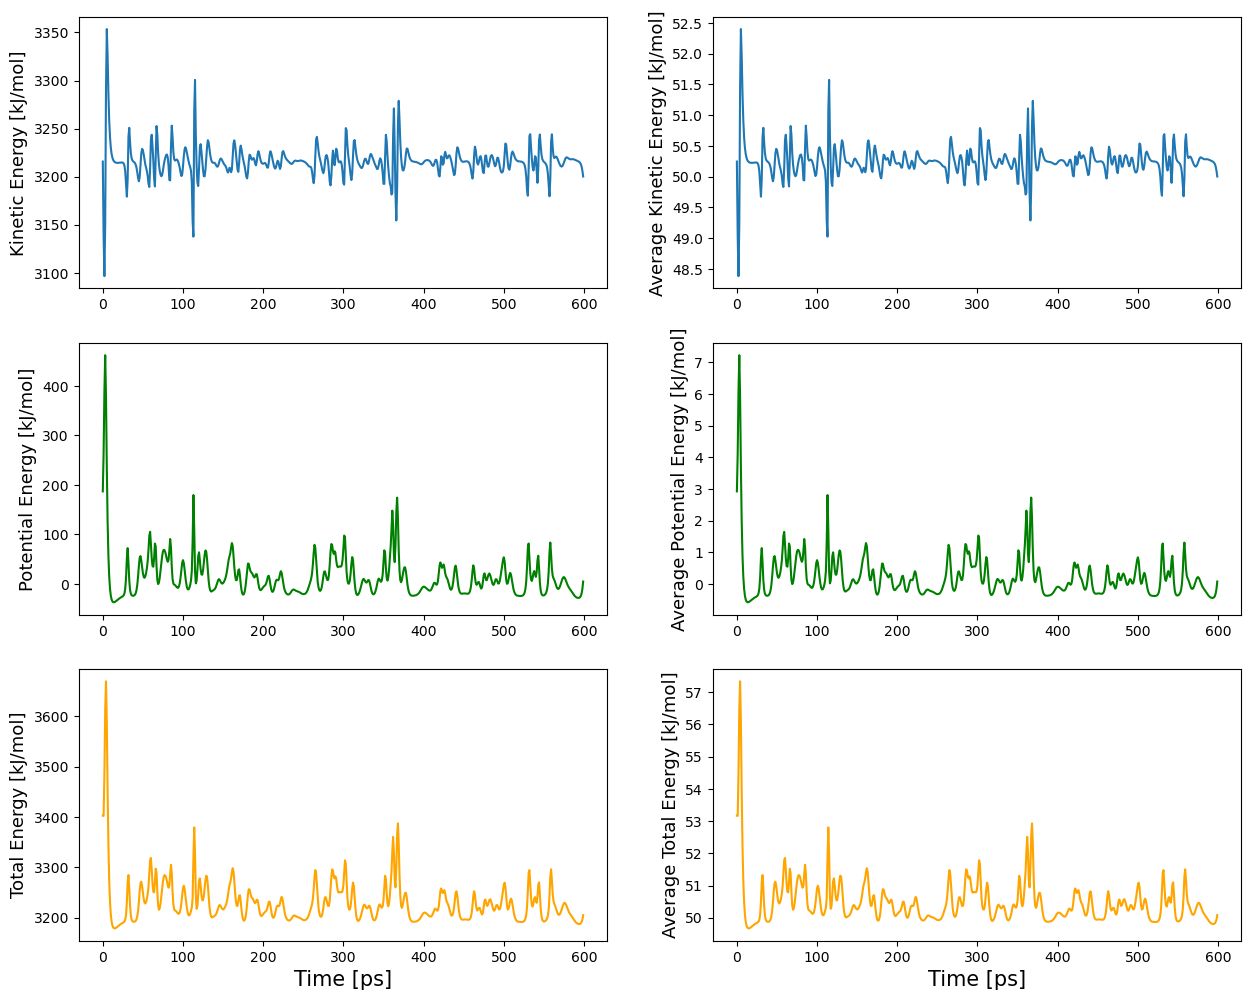

In [25]:
fig, axs = plt.subplots(3, 2, figsize=[15,12])
axs[0, 0].plot(E_kin[:600])
axs[0, 0].set_ylabel('Kinetic Energy [kJ/mol]',fontsize=13)
axs[0, 1].plot(E_kin_avg[:600])
axs[0, 1].set_ylabel('Average Kinetic Energy [kJ/mol]',fontsize=13)
axs[1, 0].plot(E_pot[:600], 'green')
axs[1, 0].set_ylabel('Potential Energy [kJ/mol]',fontsize=13)
axs[1, 1].plot(E_pot_avg[:600], 'green')
axs[1, 1].set_ylabel('Average Potential Energy [kJ/mol]',fontsize=13)
axs[2, 0].plot(E_tot[:600], 'orange')
axs[2, 0].set_ylabel('Total Energy [kJ/mol]',fontsize=13)
axs[2, 0].set_xlabel('Time [ps]',fontsize=15)
axs[2, 1].plot(E_tot_avg[:600], 'orange')
axs[2, 1].set_ylabel('Average Total Energy [kJ/mol]',fontsize=13)
axs[2, 1].set_xlabel('Time [ps]',fontsize=15)
#plt.savefig('Arg_64_energies.png')
plt.show()

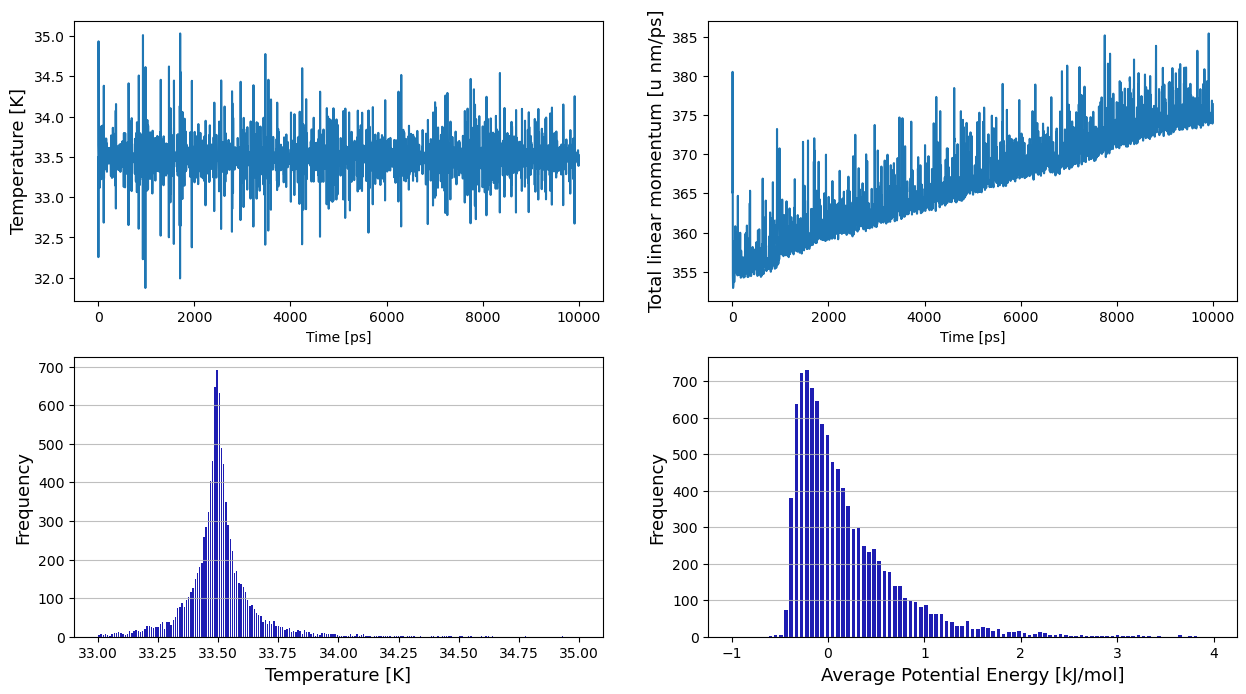

In [26]:
fig, axs = plt.subplots(2, 2, figsize=[15,8])

axs[0, 0].plot(T)
axs[0, 0].set_ylabel('Temperature [K]',fontsize=13)
axs[0, 0].set_xlabel('Time [ps]',fontsize=10)
axs[0, 1].plot(P)
axs[0, 1].set_ylabel('Total linear momentum [u nm/ps]',fontsize=13)
axs[0, 1].set_xlabel('Time [ps]',fontsize=10)
axs[1, 0].hist(x=T, bins='auto', range=(33,35), color='#0504aa', alpha=0.9, rwidth=0.65, linewidth=15)
axs[1, 0].grid(axis='y', alpha=0.8)
axs[1, 0].set_xlabel('Temperature [K]', fontsize=13)
axs[1, 0].set_ylabel('Frequency', fontsize=13)
axs[1, 1].hist(x=E_pot_avg, bins='auto', range=(-1,4), color='#0504aa', alpha=0.9, rwidth=0.7)
axs[1, 1].grid(axis='y', alpha=0.8)
axs[1, 1].set_xlabel('Average Potential Energy [kJ/mol]', fontsize=13)
axs[1, 1].set_ylabel('Frequency', fontsize=13)
#plt.savefig("Arg_64_prop.png")
plt.show()

In [17]:
print("expected value for T: ",sum(T)/n_steps)
print("expected value for average potential energy: ",sum(E_pot_avg)/n_steps)
print("expected value for average total energy: ",sum(E_tot_avg)/n_steps)

expected value for T:  37.904765629768846
expected value for average potential energy:  0.19834287034081563
expected value for average total energy:  57.05549131499409


In [18]:
print(std(T))
print(std(E_pot_avg))
print(std(E_tot_avg))

0.16759570970115653
0.5547924819491982
0.5525313479030484


In [19]:
energy_drift = sum(abs((E_tot[0]-E_tot)/E_tot))/N

In [20]:
energy_drift

7.420199040567329